# Main Pipeline - Project_SSL

Prepared by: Svetlana SANNIKOVA

The full project workflow consists of the following steps:

1. Baseline training 
2. Pathway score computation (GSEA)  
3. Self-supervised pretraining
4. Fine-tuning 
5. Visualization

## 1. Baseline training

Trains a simple classifier (MLP) on the processed data using `baseline.py`.

In [4]:
from baseline import run_baseline

results = run_baseline(
    finetune_path="data/finetune.parquet",
    test_path="data/test.parquet",
    epochs=50
)


n=100: mean_acc=0.7462 ± 0.0194
n=200: mean_acc=0.8150 ± 0.0150
n=300: mean_acc=0.8704 ± 0.0100
n=400: mean_acc=0.8688 ± 0.0139
n=500: mean_acc=0.8960 ± 0.0093
n=600: mean_acc=0.9108 ± 0.0025
n=700: mean_acc=0.9152 ± 0.0047
n=800: mean_acc=0.9154 ± 0.0094
n=900: mean_acc=0.9182 ± 0.0138
n=1000: mean_acc=0.9154 ± 0.0136
Baseline results saved to baseline_results.npz


In [5]:
from visualization import plot_baseline_performance

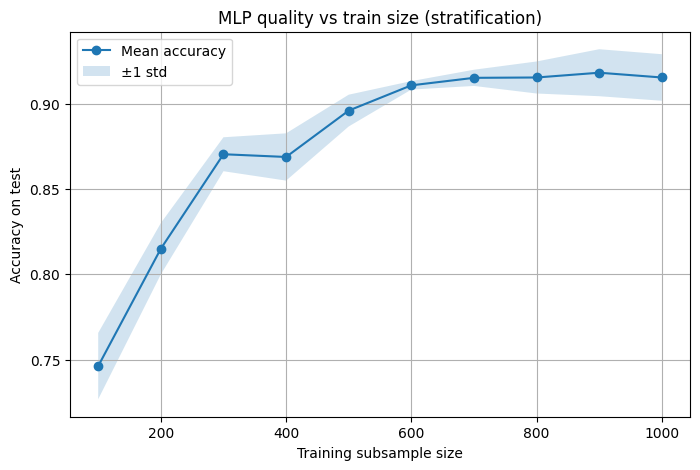

In [6]:
plot_baseline_performance(save_path="results/baseline/baseline_curve.png")

## 2. Pathway score computation (GSEA

### Gene ID Mapping (ENSG → Gene Symbol)

In [2]:
from mapping import run_mapping
import pandas as pd

# Load datasets
pretrain = pd.read_parquet("data/pretrain.parquet")
finetune = pd.read_parquet("data/finetune.parquet")
test = pd.read_parquet("data/test.parquet")

# Map ENSG -> gene symbols
pretrain_mapped = run_mapping(pretrain)
finetune_mapped = run_mapping(finetune)
test_mapped = run_mapping(test)

print("Pretrain mapped shape:", pretrain_mapped.shape)
print("Fine-tune mapped shape:", finetune_mapped.shape)
print("Test mapped shape:", test_mapped.shape)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000175711', 2)]
6 input query terms found no hit:	['ENSG00000169789', 'ENSG00000139656', 'ENSG00000148362', 'ENSG00000168078', 'ENSG00000189144', 'ENS
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000175711', 2)]
6 input query terms found no hit:	['ENSG00000169789', 'ENSG00000139656', 'ENSG00000148362', 'ENSG00000168078', 'ENSG00000189144', 'ENS
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000175711', 2)]
6 input query terms found no hit:	['ENSG00000169789', 'ENSG00000139656', 'ENSG00000148362',

Pretrain mapped shape: (7349, 19706)
Fine-tune mapped shape: (1000, 19706)
Test mapped shape: (1000, 19706)


In [3]:
pretrain_mapped.to_parquet("data/results_mapped/pretrain_mapped.parquet")
finetune_mapped.to_parquet("data/results_mapped/finetune_mapped.parquet")
test_mapped.to_parquet("data/results_mapped/test_mapped.parquet")

### Pathway profile computation (ssGSEA on KEGG gene sets)

In [17]:
from pathways import run_pathway, save_pathway_profiles

KEGG_GMT = "data/kegg.gmt"

pretrain_pathways = run_pathway(pretrain_mapped, gene_set="KEGG", gmt_path=KEGG_GMT)
# finetune_pathways = run_pathway(finetune_mapped, gene_set="KEGG", gmt_path=KEGG_GMT)
# test_pathways = run_pathway(test_mapped, gene_set="KEGG", gmt_path=KEGG_GMT)

print(pretrain_pathways.shape) #finetune_pathways.shape, test_pathways.shape)

# Save
save_pathway_profiles(pretrain_pathways, "data/pathways/pretrain_pathways", fmt="parquet")
# save_pathway_profiles(finetune_pathways, "data/processed/finetune_pathways", fmt="parquet")
# save_pathway_profiles(test_pathways, "data/processed/test_pathways", fmt="parquet")

In [19]:
finetune_pathways = run_pathway(finetune_mapped, gene_set="KEGG", gmt_path=KEGG_GMT)
save_pathway_profiles(finetune_pathways, "data/pathways/finetune_pathways", fmt="parquet")

In [20]:
test_pathways = run_pathway(test_mapped, gene_set="KEGG", gmt_path=KEGG_GMT)
save_pathway_profiles(test_pathways, "data/pathways/test_pathways", fmt="parquet")

## 3. Self-supervised pretraining
Learns latent representations from unlabeled gene expression using a self-supervised objective.


In [21]:
from ssl_pretrain import run_pretrain, SSLPretrainConfig

cfg = SSLPretrainConfig(
    epochs=50,
    batch_size=64,
    lr=1e-3,
    save_dir="experiments/ssl_pretrain_run1"
)

model = run_pretrain(pretrain_mapped, pretrain_pathways, config=cfg)

[SSL] Pretraining on cuda for 50 epochs
[SSL] Epoch 010/50 | avg_loss=0.4843
[SSL] Epoch 020/50 | avg_loss=0.4706
[SSL] Epoch 030/50 | avg_loss=0.4604
[SSL] Epoch 040/50 | avg_loss=0.4549
[SSL] Epoch 050/50 | avg_loss=0.4502
[SSL] Done. Saved model to: experiments/ssl_pretrain_run1/ssl_model.pth
[SSL] Saved config to: experiments/ssl_pretrain_run1/config.json


## 4. Fine-tuning
Trains a classifier on top of the pretrained encoder for cancer-type prediction using labeled data.

In [4]:
from ssl_pretrain import load_pretrained_encoder
from ssl_finetune import run_finetune

# Load SSL pretrained encoder
ssl_encoder = load_pretrained_encoder(
    "experiments/ssl_pretrain_run1/ssl_model.pth",
    "experiments/ssl_pretrain_run1/config.json"
)

print("Freeze_encoder=True")
run_finetune(
    encoder=ssl_encoder,
    finetune_df=finetune_mapped,
    test_df=test_mapped,
    epochs=50,
    freeze_encoder=True)

print("Freeze_encoder=False")
run_finetune(
    encoder=ssl_encoder,
    finetune_df=finetune_mapped,
    test_df=test_mapped,
    epochs=50,
    freeze_encoder=False)

[SSL] Loaded encoder from: experiments/ssl_pretrain_run1/ssl_model.pth
Freeze_encoder=True
Prop 0.1 → Mean Acc = 0.8410
Prop 0.2 → Mean Acc = 0.8906
Prop 0.3 → Mean Acc = 0.9064
Prop 0.4 → Mean Acc = 0.9156
Prop 0.5 → Mean Acc = 0.9152
Prop 0.6 → Mean Acc = 0.9246
Prop 0.7 → Mean Acc = 0.9242
Prop 0.8 → Mean Acc = 0.9244
Prop 0.9 → Mean Acc = 0.9280
Prop 1.0 → Mean Acc = 0.9296
Freeze_encoder=False
Prop 0.1 → Mean Acc = 0.8352
Prop 0.2 → Mean Acc = 0.8906
Prop 0.3 → Mean Acc = 0.9074
Prop 0.4 → Mean Acc = 0.9168
Prop 0.5 → Mean Acc = 0.9156
Prop 0.6 → Mean Acc = 0.9240
Prop 0.7 → Mean Acc = 0.9270
Prop 0.8 → Mean Acc = 0.9256
Prop 0.9 → Mean Acc = 0.9290
Prop 1.0 → Mean Acc = 0.9296


,proportion,mean,std,run1,run2,run3,run4,run5
0,0.1,0.8352,0.010245,0.834,0.838,0.836,0.818,0.850
1,0.2,0.8906,0.005083,0.899,0.891,0.892,0.887,0.884
2,0.3,0.9074,0.006974,0.918,0.911,0.908,0.902,0.898
3,0.4,0.9168,0.004915,0.923,0.909,0.916,0.915,0.921
4,0.5,0.9156,0.004079,0.921,0.911,0.913,0.920,0.913
5,0.6,0.9240,0.002898,0.923,0.924,0.920,0.929,0.924
6,0.7,0.9270,0.002683,0.926,0.926,0.924,0.927,0.932
7,0.8,0.9256,0.002577,0.926,0.925,0.925,0.930,0.922
8,0.9,0.9290,0.002098,0.930,0.925,0.931,0.929,0.930
9,1.0,0.9296,0.001020,0.930,0.928,0.930,0.929,0.931


## 5. Visualization

FileNotFoundError: [Errno 2] No such file or directory: '/home/sharp_davinci/workdir/Project/results/figures/baseline_vs_ssl.png'

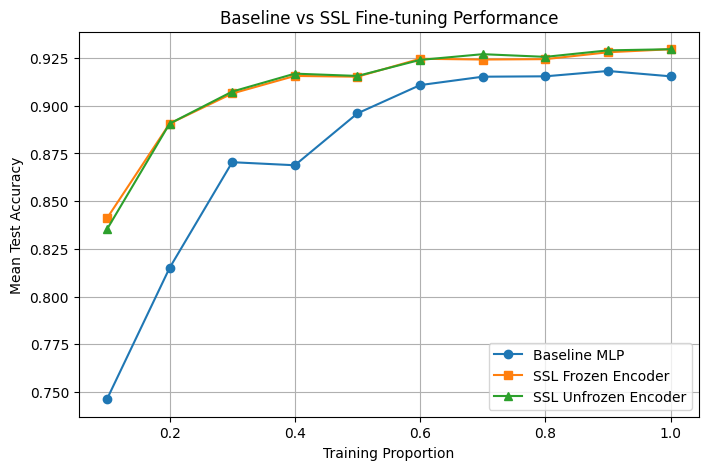

In [5]:
from visualization import compare_training_curves

compare_training_curves(
    baseline_npz="baseline_results.npz",
    ssl_frozen_csv="results/ssl/ssl_finetune_frozen.csv",
    ssl_unfrozen_csv="results/ssl/ssl_finetune_unfrozen.csv",
    save_path="results/figures/baseline_vs_ssl.png"  
)


In [1]:
from summary import summarize_baseline, summarize_ssl_encoder
from baseline import MLP
from ssl_pretrain import GeneSSLModel

# Baseline summary
summarize_baseline(baseline_model_class=MLP)

# SSL encoder summary
summarize_ssl_encoder(ssl_model_class=GeneSSLModel)


==================== BASELINE MODEL SUMMARY ====================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]      10,182,656
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                   [-1, 19]           4,883
Total params: 10,318,867
Trainable params: 10,318,867
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.02
Params size (MB): 39.36
Estimated Total Size (MB): 39.46
----------------------------------------------------------------


==================== SSL ENCOD

C:\Users\DELL\DeepLearning\summary.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ssl_weight_path, map_location="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      20,178,944
              ReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
              ReLU-8                  [-1, 256]               0
         LayerNorm-9                  [-1, 256]             512
Total params: 20,835,584
Trainable params: 20,835,584
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.04
Params size (MB): 79.48
Estimated Total Size (MB): 79.60
-----------------------------------